In [1]:
# from geojson import Point, Feature, FeatureCollection, dump
from shapely.geometry import Polygon, LineString, Point
import requests
import geojson
from pathlib import Path
import os
import rioxarray
from dotenv import load_dotenv
# from osgeo import ogr
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
from osgeo import gdal
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from rasterio.crs import CRS
from rasterio.transform import Affine


load_dotenv()
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/tobfer/code/noc/imfepilot/bodc-code/scripts/files_to_raster_vector_grid/')

In [3]:
!pwd

/home/tobfer/code/soutobias/wekeo/image-conversion-galene/notebooks


In [4]:
gdf = gpd.read_file('../image-conversion-galene/data/dataframe.gpkg', crs="epsg:4326")

In [6]:
months = gdf.time.unique()
depths =  gdf.depth.unique()
variables = ['chl', 'phyc', 'no3', 'po4', 'o2', 'ph',
       'so', 'zos', 'avg_temp_C']

In [8]:
np.sort(months)

array(['2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06',
       '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12',
       '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06',
       '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12',
       '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', 

In [340]:
file_base_path = '../image-conversion-galene/output/'
flag = True
for month in months:
    for depth in depths:        
        month_gdf = gdf[gdf.time == month]
        month_gdf = month_gdf[month_gdf.depth == depth]
        month_gdf.drop(columns=['depth', 'time'], inplace=True)
        if flag:
            unique_lon = month_gdf.lon.unique()
            unique_lat = month_gdf.lat.unique()
            values = []
            for lon in unique_lon:
                for lat in unique_lat:
                    if month_gdf[(month_gdf.lon == lon)&(month_gdf.lat == lat)].empty:
                        values.append([lat, lon, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
            new_df = pd.DataFrame(values, columns=month_gdf.columns[0:-1])
            new_gdf = gpd.GeoDataFrame(
                new_df, geometry=gpd.points_from_xy(new_df.lon, new_df.lat), crs="EPSG:4326"
            )
            flag=False
        
        month_gdf = pd.concat((month_gdf, new_gdf))
        month_gdf.sort_values(by=['lat', 'lon'], ascending = [True, False], inplace=True)
        month_gdf.rename(columns={'lat': 'y', 'lon': 'x'}, inplace=True)
        da = month_gdf.set_index(['y', 'x']).to_xarray()
        da.rio.write_crs("epsg:4326", inplace=True)
        for var in variables:
            da[var].rio.to_raster(f'{file_base_path}{var}_{depth}_{month}.tiff')  

In [331]:
month_gdf = gdf[gdf.time == months[0]]
month_gdf = month_gdf[month_gdf.depth == depths[0]]
month_gdf.drop(columns=['depth', 'time'], inplace=True)

In [332]:
unique_lon = month_gdf.lon.unique()
unique_lat = month_gdf.lat.unique()

In [333]:
values = []
for lon in unique_lon:
    for lat in unique_lat:
        if month_gdf[(month_gdf.lon == lon)&(month_gdf.lat == lat)].empty:
            values.append([lat, lon, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

In [334]:
new_df = pd.DataFrame(values, columns=month_gdf.columns[0:-1])

In [335]:
new_gdf = gpd.GeoDataFrame(
    new_df, geometry=gpd.points_from_xy(new_df.lon, new_df.lat), crs="EPSG:4326"
)
month_gdf = pd.concat((month_gdf, new_gdf))

In [336]:
month_gdf.sort_values(by=['lat', 'lon'], ascending = [True, False], inplace=True)

In [337]:
month_gdf.rename(columns={'lat': 'y', 'lon': 'x'}, inplace=True)
da = month_gdf.set_index(['y', 'x']).to_xarray()
# da = da.sortby(["y", "x"]) # THIS SOLVED THE PROBLEM
da.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (y: 28, x: 55)
Coordinates:
  * y            (y) float64 42.44 42.48 42.52 42.56 ... 43.44 43.48 43.52 43.56
  * x            (x) float64 8.917 8.958 9.0 9.042 ... 11.04 11.08 11.12 11.17
    spatial_ref  int64 0
Data variables:
    chl          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    phyc         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    no3          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    po4          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    o2           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ph           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    so           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    zos          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    avg_temp_C   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    geometry     (y, x) object POINT (8.916666984558105 42.4375) ... POINT (1...

In [338]:
da.chl.rio.to_raster('teste.tif')

In [327]:
x = rasterio.open('teste.tif')

In [328]:
x.bounds

BoundingBox(left=8.895833651224772, bottom=43.58333333333333, right=11.187500317891438, top=42.416666666666664)

In [250]:
transform = Affine.translation(month_gdf.lon.min(), month_gdf.lat.min())

In [251]:
raster_crs = CRS.from_epsg(4326)
height=len(month_gdf.lat.unique())
width=len(month_gdf.lon.unique())
interp_raster = rasterio.open('interpRaster3.tif',
                        'w',
                        driver='GTiff',
                        height=height,
                        width=width,
                        count=1,
                        dtype=month_gdf.chl.dtype,
                        crs=raster_crs,
                        transform=transform,
                        )

In [ ]:
interp_raster.write(month_gdf.chl.to_numpy().reshape(height, width),1)
interp_raster.close()

In [137]:
len(month_gdf.no3.to_numpy())

1067

KeyError: "None of ['x'] are in the columns"

In [ ]:
rio

In [ ]:
interp_raster.write(month_gdf.chl.to_numpy().reshape(height, width),1)
interp_raster.close()

In [316]:
x.bounds

BoundingBox(left=42.416666666666664, bottom=11.187500317891438, right=43.58333333333333, top=8.895833651224772)

In [294]:
x = rasterio.open('my_rasterized_column.tif')
x.bounds

BoundingBox(left=8.91, bottom=43.59, right=11.19, top=42.42)

In [ ]:
raster_crs = CRS.from_epsg("epsg:4326")
raster_crs.data


interp_raster.write(grid_depth,1)
interp_raster.close()

with rasterio.open('../data/interpRaster3.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, [concave_hull], crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform})

with rasterio.Env(GTIFF_FORCE_RGBA=True):
    with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dataset:
        dataset.write(out_image)
        dataset.nodata = 0.0
        msk = dataset.read_masks(1)
        meta = dataset.meta
        meta.update(count = 2)

with rasterio.open('./RGB.test.tif', 'w', **meta) as dst:
    dst.write_band(1, dataset.read(1))
    dst.write_band(2, msk)

#delete temporary file 
# file_path_temp.unlink()

gdal.Warp('./RGB.test_cog.tif', './RGB.test.tif', format="COG", srcNodata=0, dstNodata =0,
        options=["COMPRESS=LZW", "TILED=YES"])

In [ ]:
interpRaster = rasterio.open('interpRaster3.tif',
                                'w',
                                driver='GTiff',
                                height=gridPh.shape[0],
                                width=gridPh.shape[1],
                                count=1,
                                dtype=gridPh.dtype,
                                crs="epsg:4326",
                                transform=transform,
                                )

In [139]:
out_grid= make_geocube(vector_data=month_gdf, resolution=(0.03,0.03),rasterize_function=rasterize_points_griddata)
out_grid

<xarray.Dataset>
Dimensions:      (y: 39, x: 76)
Coordinates:
  * y            (y) float64 42.44 42.47 42.5 42.53 ... 43.48 43.52 43.55 43.58
  * x            (x) float64 8.925 8.955 8.985 9.015 ... 11.09 11.12 11.14 11.18
    spatial_ref  int64 0
Data variables:
    lat          (y, x) float64 42.65 42.65 42.65 42.65 ... 43.27 43.27 43.27
    lon          (y, x) float64 8.917 8.958 9.0 9.0 9.0 ... 10.5 10.5 10.5 10.5
    depth        (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    chl          (y, x) float64 0.2204 0.2239 0.2261 ... 0.2049 0.2049 0.2049
    phyc         (y, x) float64 0.8106 0.8335 0.8471 ... 0.7553 0.7553 0.7553
    no3          (y, x) float64 1.827 1.819 1.811 1.811 ... 0.8622 0.8622 0.8622
    po4          (y, x) float64 0.09839 0.09821 0.09796 ... 0.029 0.029 0.029
    o2           (y, x) float64 242.4 242.5 242.5 242.5 ... 248.2 248.2 248.2
    ph           (y, x) float64 8.138 8.139 8.139 8.139 ... 8.171 8.171 8.171
    so           (y, x) float64 38.01 38.02 38.02 38.02 ... 37.92 37.92 37.92
    zos          (y, x) float64 -0.4922 -0.4923 -0.4926 ... -0.4244 -0.4244
    avg_temp_C   (y, x) float64 13.25 13.22 13.22 13.22 ... 13.54 13.54 13.54

In [140]:
out_grid["chl"].rio.to_raster("my_rasterized_column.tif")

In [ ]:
out_grid= make_geocube(vector_data=month_gdf, measurements=["chl"]) #for most crs negative comes first in resolution
out_grid["column_name"].rio.to_raster("my_rasterized_column.tif")

In [60]:
da.rio.crs

In [64]:
file_base_path = '../image-conversion-galene/output/'

In [160]:
da = month_gdf.to_xarray()
da

<xarray.Dataset>
Dimensions:     (index: 1067)
Coordinates:
  * index       (index) int64 0 3 6 9 12 15 18 ... 3181 3184 3187 3190 3193 3196
Data variables: (12/14)
    time        (index) object '2008-01' '2008-01' ... '2008-01' '2008-01'
    lat         (index) float64 42.44 42.44 42.44 42.44 ... 43.56 43.56 43.56
    lon         (index) float64 9.542 9.583 9.625 9.667 ... 10.21 10.25 10.29
    depth       (index) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    chl         (index) float64 0.1597 0.1531 0.1455 ... 0.3176 0.3782 0.4093
    phyc        (index) float64 0.6063 0.5674 0.5257 ... 1.611 2.047 2.289
    ...          ...
    o2          (index) float64 244.2 243.8 243.5 243.1 ... 249.0 250.4 251.1
    ph          (index) float64 8.151 8.146 8.145 8.144 ... 8.175 8.181 8.185
    so          (index) float64 38.0 38.0 37.97 37.94 ... 37.72 37.65 37.64
    zos         (index) float64 -0.4917 -0.4891 -0.4832 ... -0.4261 -0.4269
    avg_temp_C  (index) float64 13.45 13.69 13.96 14.03 ... 13.2 13.15 13.17
    geometry    (index) object POINT (9.541666984558104 42.4375) ... POINT (1...

In [59]:
file_base_path = '../image-conversion-galene/output/'
for month in months:
    for depth in depths:        
        month_gdf = gdf[gdf.time == month]
        month_gdf = month_gdf[month_gdf.depth == depth]
        da = month_gdf.to_xarray()
        da = da.rename_dims({'lat':'y', 'lon':'x'})
        for var in variables:
            da[var].rio.to_raster(f'{file_base_path}{var}_{depth}_{month}.tiff')       
    

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/tobfer/.pyenv/versions/3.10.6/envs/galene/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-s

In [61]:
import rasterio

In [65]:
src = rasterio.open(f"{file_base_path}avg_temp_C_1.0_2008-03.tiff")

In [70]:
src.crs

In [39]:
da = month_gdf.to_xarray()
da

<xarray.Dataset>
Dimensions:     (lat: 28, lon: 55)
Coordinates:
  * lat         (lat) float64 42.44 42.48 42.52 42.56 ... 43.48 43.52 43.56
  * lon         (lon) float64 8.917 8.958 9.0 9.042 ... 11.04 11.08 11.12 11.17
Data variables:
    time        (lat, lon) object nan nan nan nan nan ... nan nan nan nan nan
    depth       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    chl         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    phyc        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    no3         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    po4         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    o2          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ph          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    so          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    zos         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    avg_temp_C  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    geometry    (lat, lon) object nan nan nan nan nan ... nan nan nan nan nan

In [56]:
da = da.rename_dims({'lat':'y', 'lon':'x'})

In [58]:
da['chl'].rio.to_raster('../image-conversion-galene/output/file1.tiff')

In [34]:
rio

NameError: name 'rio' is not defined

In [7]:
from process_geojson_files import ProcessGeoFiles

In [8]:
p = ProcessGeoFiles(output='EUSeaMap_2021', output_format='geojson', local_path='../data/')

In [10]:
print('opening geojson')
df = gpd.read_file(f'../data/{p.output}.geojson')
print('data opened')

opening geojson
data opened


In [13]:
len(df.EUNIScombD.unique())

47

In [110]:
p.clip_data(round_polygons=0, drop_columns=['Oxygen', 'Salinity'], encode_values=True)

opening geojson
data opened
data clipped
data rounded
clipped_EUSeaMap_2021.geojson saved!


In [9]:
# gdf = gpd.read_file('../data/clipped_EUSeaMap_2021.geojson')
# gdf.to_geoparquet('../data/clipped_EUSeaMap_2021_2.parquet')

In [8]:
gdf_1 = gpq.read_geoparquet('../data/clipped_EUSeaMap_2021_2.parquet')
gdf_1

,Oxygen,Salinity,Energy,Biozone,Substrate,EUNIScombD,MSFD_BBHT,geometry
0,,,Low energy,Deep circalittoral,Sand,A5.27: Deep circalittoral sand,Offshore circalittoral sand,"POLYGON ((-675405.900 6410848.900, -675374.400..."
1,,,Low energy,Deep circalittoral,Rock or other hard substrata,A4.33: Faunal communities on deep low energy c...,Offshore circalittoral rock and biogenic reef,"POLYGON ((-674526.200 6410417.700, -674701.500..."
2,,,Low energy,Deep circalittoral,Rock or other hard substrata,A4.33: Faunal communities on deep low energy c...,Offshore circalittoral rock and biogenic reef,"POLYGON ((-678320.600 6410516.300, -678365.600..."
3,,,Low energy,Deep circalittoral,Coarse substrate,A5.15: Deep circalittoral coarse sediment,Offshore circalittoral coarse sediment,"POLYGON ((-675247.800 6410912.900, -675245.500..."
4,,,Low energy,Deep circalittoral,Rock or other hard substrata,A4.33: Faunal communities on deep low energy c...,Offshore circalittoral rock and biogenic reef,"POLYGON ((-675245.500 6410988.300, -675245.500..."
...,...,...,...,...,...,...,...,...
202528,,,Low energy,Infralittoral,Seabed,Na,Na,"POLYGON ((-813907.800 6824269.800, -814487.600..."
202529,,,Low energy,Infralittoral,Seabed,Na,Na,"POLYGON ((-820285.500 6824468.600, -820285.500..."
202530,,,Low energy,Infralittoral,Seabed,Na,Na,"POLYGON ((-815531.200 6824577.000, -815763.100..."
202531,,,Low energy,Infralittoral,Seabed,Na,Na,"POLYGON ((-816690.800 6824633.600, -816770.200..."


In [8]:
spacing = 100000
p.spacing = 100000

In [154]:
grid_points = p._create_grid(gdf_1)
grid_points = dd.from_pandas(grid_points, npartitions=10)

In [155]:
result_values = grid_points.apply(lambda x: ProcessGeoFiles._verify_points_in_polygon(x=x, gdf=gdf_1))

foo
'str' object has no attribute 'within'
foo
'str' object has no attribute 'within'
foo
'str' object has no attribute 'within'
foo
'str' object has no attribute 'within'


/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/dask/dataframe/core.py:4343: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [156]:
r = result_values.compute()

POINT (-1413232 6288190)POINT (-1213232 6888190)

POINT (-913232 6688190)
POINT (-613232 6488190)
POINT (-1113232 6288190)
POINT (-1413232 6388190)
POINT (-1113232 6388190)
POINT (-613232 6588190)
POINT (-1413232 6488190)
POINT (-1113232 6488190)
POINT (-1113232 6588190)
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
POINT (-613232 6688190)
POINT (-1413232 6588190)
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
POINT (-613232 6788190)
POINT (-1113232 6688190)
POINT (-613232 6888190)
POINT (-1113232 6788190)
POINT (-1413232 6688190)
POINT (-513232 6288190)
POINT (-1113232 6888190)
POINT (-1013232 6288190)
POINT (-513232 6388190)
POINT (-1413232 6788190)
POINT (-513232 6488190)
POINT (-1413232 6888190)
POINT (-1013232 6388190)
POINT (-513232 6588190)
POINT (-1313232 6288190)
POINT (-513232 6688190)
POINT (-1313232 63

In [96]:
x = [None]*len(gdf_1.iloc[0].values)
gdf_1 = gdf_1.append(pd.DataFrame([x],index=[-1],columns=gdf_1.columns))
gdf_1

/tmp/ipykernel_45894/3890193543.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf_1 = gdf_1.append(pd.DataFrame([x],index=[-1],columns=gdf_1.columns))
/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


,Oxygen,Salinity,Energy,Biozone,Substrate,EUNIScombD,MSFD_BBHT,geometry
0,,,Low energy,Deep circalittoral,Sand,A5.27: Deep circalittoral sand,Offshore circalittoral sand,"POLYGON ((-675405.900 6410848.900, -675374.400..."
1,,,Low energy,Deep circalittoral,Rock or other hard substrata,A4.33: Faunal communities on deep low energy c...,Offshore circalittoral rock and biogenic reef,"POLYGON ((-674526.200 6410417.700, -674701.500..."
2,,,Low energy,Deep circalittoral,Rock or other hard substrata,A4.33: Faunal communities on deep low energy c...,Offshore circalittoral rock and biogenic reef,"POLYGON ((-678320.600 6410516.300, -678365.600..."
3,,,Low energy,Deep circalittoral,Coarse substrate,A5.15: Deep circalittoral coarse sediment,Offshore circalittoral coarse sediment,"POLYGON ((-675247.800 6410912.900, -675245.500..."
4,,,Low energy,Deep circalittoral,Rock or other hard substrata,A4.33: Faunal communities on deep low energy c...,Offshore circalittoral rock and biogenic reef,"POLYGON ((-675245.500 6410988.300, -675245.500..."
...,...,...,...,...,...,...,...,...
202529,,,Low energy,Infralittoral,Seabed,Na,Na,"POLYGON ((-820285.500 6824468.600, -820285.500..."
202530,,,Low energy,Infralittoral,Seabed,Na,Na,"POLYGON ((-815531.200 6824577.000, -815763.100..."
202531,,,Low energy,Infralittoral,Seabed,Na,Na,"POLYGON ((-816690.800 6824633.600, -816770.200..."
202532,,,No energy information,Infralittoral,Seabed,Na,Na,"POLYGON ((-820517.400 6824377.300, -820517.400..."


In [157]:
r

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
72         NaN
73         NaN
74    179233.0
75         NaN
76         NaN
Length: 77, dtype: float64

In [98]:
result_values[result_values.isna()]=int(-1)
result_values = result_values.astype(int)
result_values

0         -1
1         -1
2         -1
3         -1
4         -1
       ...  
72        -1
73        -1
74    179233
75        -1
76        -1
Length: 77, dtype: int64

In [ ]:
columns = gdf_1.drop(columns='geometry')

In [150]:
ds = xr.Dataset(
    coords=dict(
        lon=('lon', p.dx),
        lat=('lat', p.dy),
    )
)

compressor = zarr.Blosc(cname="zlib", clevel=2, shuffle=1)
encoding_settings = {}

for column in columns:
    da_name = column
    da = xr.DataArray(
        gdf_1[column].loc[result_values].to_numpy().reshape(len(p.dx), len(p.dy)),
        name=da_name,
        dims=('lon', 'lat')
    )
    ds[da_name] = da
    encoding_settings[da_name] = {'_FillValue': '', 'compressor': compressor, 'chunks': (2500, 1000, 1000)}


In [152]:
f'{p.local_path}teste'

'../data/teste'

In [153]:
# store = zarr.storage.FSStore(os.environ['PANGEO_SCRATCH'] + "zarr_write_test_2")
ds.to_zarr(f'{p.local_path}teste', mode='w', encoding=encoding_settings, consolidated=True)

In [138]:
ds

<xarray.Dataset>
Dimensions:     (lon: 11, lat: 7)
Coordinates:
  * lon         (lon) float64 -1.413e+06 -1.313e+06 ... -5.132e+05 -4.132e+05
  * lat         (lat) float64 6.288e+06 6.388e+06 ... 6.788e+06 6.888e+06
Data variables:
    Oxygen      (lon, lat) object None None None None ... None ' ' None None
    Salinity    (lon, lat) object None None None None ... None ' ' None None
    Energy      (lon, lat) object None None None ... 'High energy' None None
    Biozone     (lon, lat) object None None None ... None None
    Substrate   (lon, lat) object None None None ... None None
    EUNIScombD  (lon, lat) object None None None ... None None
    MSFD_BBHT   (lon, lat) object None None None ... None None

In [113]:
gdf = gpd.read_file(f'{p.local_path}{p.file_clipped}.geojson')
gdf.to_parquet(f'{p.local_path}{p.file_clipped}.parquet')

In [126]:
vector_fn = f'{p.local_path}clipped_EUSeaMap_2021.geojson'
vector_fn

'../data/clipped_EUSeaMap_2021.geojson'

In [127]:
raster_fn = f'{p.local_path}clipped_EUSeaMap_2021.tif'
raster_fn

'../data/clipped_EUSeaMap_2021.tif'

In [129]:
source_ds = gdal.OpenEx(vector_fn)

In [130]:
layer = source_ds.GetLayerByIndex(0)

In [28]:
geometry = layer.GetGeomType()

In [131]:
from osgeo import ogr
geometry_name = ogr.GeometryTypeToName(geometry)
print("The layer's geometry is: {geom}\n".format(geom=geometry_name))

The layer's geometry is: Polygon



In [132]:
### What is the layer's projection?
# Get the spatial reference
spatial_ref = layer.GetSpatialRef()

# Export this spatial reference to something we can read... like the Proj4
proj4 = spatial_ref.ExportToProj4()
print('Layer projection is: {proj4}\n'.format(proj4=proj4))

### How many features are in the layer?
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

Layer projection is: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs

Layer has 202533 features



In [133]:
### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# How many fields
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))

Layer has 5 fields
Their names are: 
	Energy - Real
	Biozone - Real
	Substrate - Real
	EUNIScombD - Real
	MSFD_BBHT - Real


In [134]:
pixel_size = 0.01  # about 25 metres(ish) use 0.001 if you want roughly 100m

In [ ]:
gdal.Rasterize(raster_fn,
               source_ds,
               format='GTIFF',
               outputType=gdal.GDT_Byte,
               creationOptions=["COMPRESS=LZW", "BIGTIFF=YES"],
               noData=' ',
               initValues=' ', 
               xRes=pixel_size,
               yRes=-pixel_size,
               allTouched=True,
               burnValues=1)

In [27]:
geojson = geojsplit.GeoJSONBatchStreamer("../data/arquivo.geojson")

In [28]:
for features in geojson.stream():
    print(features[0])

{'type': 'Feature', 'properties': {'OBJECTID': 216362, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Low energy', 'Biozone': 'Atlantic upper abyssal', 'Substrate': 'Seabed', 'EUNIScomb': 'A6', 'EUNIScombD': 'A6: Deep-sea bed', 'Allcomb': 'Atlantic upper abyssal seabed', 'AllcombD': 'Atlantic upper abyssal seabed', 'SalcombD': ' ', 'MSFD_BBHT': 'Abyssal', 'EUNIS2019C': 'Na', 'EUNIS2019D': 'Na', 'All2019D': 'Atlantic upper abyssal seabed', 'All2019DL2': 'Abyssal seabed', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('596.22520000487566'), 'Shape_Area': Decimal('21122.276487338113')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-12, 50], [-12, 50], [-12, 50], [-12, 50], [-12, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 216462, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Low energy', 'Biozone': 'Atlantic lower bathyal', 'Substrate': 'Seabed', 'EUNIScomb': 'A6', 'EUNIScombD': 'A6: Deep-sea bed', 'Allcomb': 'Atlantic lower

{'type': 'Feature', 'properties': {'OBJECTID': 219087, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Moderate energy', 'Biozone': 'Deep circalittoral', 'Substrate': 'Muddy sand', 'EUNIScomb': 'A5.37', 'EUNIScombD': 'A5.37: Deep circalittoral mud', 'Allcomb': 'A5.37', 'AllcombD': 'A5.37: Deep circalittoral mud', 'SalcombD': ' ', 'MSFD_BBHT': 'Offshore circalittoral mud', 'EUNIS2019C': 'MD62', 'EUNIS2019D': 'MD62: Atlantic offshore circalittoral mud', 'All2019D': 'MD62: Atlantic offshore circalittoral mud', 'All2019DL2': 'MD6: Offshore circalittoral mud', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('914.14413349500023'), 'Shape_Area': Decimal('34471.213382121859')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-9, 50], [-9, 50], [-9, 50], [-9, 50], [-9, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 219250, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Low energy', 'Biozone': 'Deep circalittoral', 'Substrate': 'Muddy sand'

{'type': 'Feature', 'properties': {'OBJECTID': 221739, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Infralittoral', 'Substrate': 'Sand', 'EUNIScomb': 'A5.23 or A5.24', 'EUNIScombD': 'A5.23 or A5.24: Infralittoral fine sand or Infralittoral muddy sand', 'Allcomb': 'A5.23 or A5.24', 'AllcombD': 'A5.23 or A5.24: Infralittoral fine sand or Infralittoral muddy sand', 'SalcombD': ' ', 'MSFD_BBHT': 'Infralittoral sand', 'EUNIS2019C': 'MB52', 'EUNIS2019D': 'MB52: Atlantic infralittoral sand', 'All2019D': 'MB52: Atlantic infralittoral sand', 'All2019DL2': 'MB5: Infralittoral sand', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('624.15446209629738'), 'Shape_Area': Decimal('6422.286322447686')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 221839, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Moderate energy', 'Biozon

{'type': 'Feature', 'properties': {'OBJECTID': 223939, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Low energy', 'Biozone': 'Shallow circalittoral', 'Substrate': 'Seabed', 'EUNIScomb': 'Na', 'EUNIScombD': 'Na', 'Allcomb': 'Low energy circalittoral seabed', 'AllcombD': 'Low energy circalittoral seabed', 'SalcombD': ' ', 'MSFD_BBHT': 'Na', 'EUNIS2019C': 'Na', 'EUNIS2019D': 'Na', 'All2019D': 'Atlantic circalittoral seabed', 'All2019DL2': 'Circalittoral seabed', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('786.95665484039716'), 'Shape_Area': Decimal('24769.205261521161')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-6, 50], [-6, 50], [-6, 50], [-6, 50], [-6, 50], [-6, 50], [-6, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 224039, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Infralittoral', 'Substrate': 'Rock or other hard substrata', 'EUNIScomb': 'A3.1', 'EUNIScombD': 'A3.1: Atlantic and Medit

{'type': 'Feature', 'properties': {'OBJECTID': 225473, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Infralittoral', 'Substrate': 'Coarse substrate', 'EUNIScomb': 'A5.13', 'EUNIScombD': 'A5.13: Infralittoral coarse sediment', 'Allcomb': 'A5.13', 'AllcombD': 'A5.13: Infralittoral coarse sediment', 'SalcombD': ' ', 'MSFD_BBHT': 'Infralittoral coarse sediment', 'EUNIS2019C': 'MB32', 'EUNIS2019D': 'MB32: Atlantic infralittoral coarse sediment', 'All2019D': 'MB32: Atlantic infralittoral coarse sediment', 'All2019DL2': 'MB3: Infralittoral coarse sediment', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('673.21954731621679'), 'Shape_Area': Decimal('24202.12126167395')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 225573, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Infralittoral

{'type': 'Feature', 'properties': {'OBJECTID': 227173, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Shallow circalittoral', 'Substrate': 'Coarse substrate', 'EUNIScomb': 'A5.14', 'EUNIScombD': 'A5.14: Circalittoral coarse sediment', 'Allcomb': 'A5.14', 'AllcombD': 'A5.14: Circalittoral coarse sediment', 'SalcombD': ' ', 'MSFD_BBHT': 'Circalittoral coarse sediment', 'EUNIS2019C': 'MC32', 'EUNIS2019D': 'MC32: Atlantic circalittoral coarse sediment', 'All2019D': 'MC32: Atlantic circalittoral coarse sediment', 'All2019DL2': 'MC3: Circalittoral coarse sediment', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('2474.3533814656862'), 'Shape_Area': Decimal('123993.86664905208')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [-4, 50], [

{'type': 'Feature', 'properties': {'OBJECTID': 228473, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Shallow circalittoral', 'Substrate': 'Rock or other hard substrata', 'EUNIScomb': 'A4.1', 'EUNIScombD': 'A4.1: Atlantic and Mediterranean high energy circalittoral rock', 'Allcomb': 'A4.1', 'AllcombD': 'A4.1: Atlantic and mediterranean high energy circalittoral rock', 'SalcombD': ' ', 'MSFD_BBHT': 'Circalittoral rock and biogenic reef', 'EUNIS2019C': 'MC12', 'EUNIS2019D': 'MC12: Atlantic circalittoral rock', 'All2019D': 'MC12: Atlantic circalittoral rock', 'All2019DL2': 'MC1: Circalittoral rock', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('844.86246789924292'), 'Shape_Area': Decimal('34217.397486930779')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 228

{'type': 'Feature', 'properties': {'OBJECTID': 229373, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Shallow circalittoral', 'Substrate': 'Sediment', 'EUNIScomb': 'A5', 'EUNIScombD': 'A5: Sublittoral sediment', 'Allcomb': 'Shallow circalittoral sediment', 'AllcombD': 'Shallow circalittoral sediment', 'SalcombD': ' ', 'MSFD_BBHT': 'Na', 'EUNIS2019C': 'Na', 'EUNIS2019D': 'Na', 'All2019D': 'Atlantic circalittoral sediment', 'All2019DL2': 'Circalittoral sediment', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('173.3514469782294'), 'Shape_Area': Decimal('1438.1370698591129')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-5, 50], [-5, 50], [-5, 50], [-5, 50], [-5, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 229473, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Moderate energy', 'Biozone': 'Shallow circalittoral', 'Substrate': 'Sediment', 'EUNIScomb': 'A5', 'EUNIScombD': 'A5: Sublittoral sediment', '

{'type': 'Feature', 'properties': {'OBJECTID': 232506, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Moderate energy', 'Biozone': 'Deep circalittoral', 'Substrate': 'Coarse substrate', 'EUNIScomb': 'A5.15', 'EUNIScombD': 'A5.15: Deep circalittoral coarse sediment', 'Allcomb': 'A5.15', 'AllcombD': 'A5.15: Deep circalittoral coarse sediment', 'SalcombD': ' ', 'MSFD_BBHT': 'Offshore circalittoral coarse sediment', 'EUNIS2019C': 'MD32', 'EUNIS2019D': 'MD32: Atlantic offshore circalittoral coarse sediment', 'All2019D': 'MD32: Atlantic offshore circalittoral coarse sediment', 'All2019DL2': 'MD3: Offshore circalittoral coarse sediment', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('566.60542958445706'), 'Shape_Area': Decimal('12619.828390399856')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-6, 50], [-6, 50], [-6, 50], [-6, 50], [-6, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 232606, 'Oxygen': ' ', 'Salinity': ' ', 'Ene

{'type': 'Feature', 'properties': {'OBJECTID': 233282, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Low energy', 'Biozone': 'Deep circalittoral', 'Substrate': 'Rock or other hard substrata', 'EUNIScomb': 'A4.33', 'EUNIScombD': 'A4.33: Faunal communities on deep low energy circalittoral rock', 'Allcomb': 'A4.33', 'AllcombD': 'A4.33: Faunal communities on deep low energy circalittoral rock', 'SalcombD': ' ', 'MSFD_BBHT': 'Offshore circalittoral rock and biogenic reef', 'EUNIS2019C': 'MD12', 'EUNIS2019D': 'MD12: Atlantic offshore circalittoral rock', 'All2019D': 'MD12: Atlantic offshore circalittoral rock', 'All2019DL2': 'MD1: Offshore circalittoral rock', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('317.92073811602131'), 'Shape_Area': Decimal('5711.7669062707573')}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-7, 50], [-7, 50], [-7, 50], [-7, 50], [-7, 50], [-7, 50], [-7, 50]]]}}
{'type': 'Feature', 'properties': {'OBJECTID':

KeyboardInterrupt: 

In [23]:
from decimal import Decimal
x = Decimal('596.22520000487566')

In [26]:
round(x)

596

In [15]:
for features in geojson.stream():
    print(features[0])


{'type': 'Feature', 'properties': {'OBJECTID': 216362, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Low energy', 'Biozone': 'Atlantic upper abyssal', 'Substrate': 'Seabed', 'EUNIScomb': 'A6', 'EUNIScombD': 'A6: Deep-sea bed', 'Allcomb': 'Atlantic upper abyssal seabed', 'AllcombD': 'Atlantic upper abyssal seabed', 'SalcombD': ' ', 'MSFD_BBHT': 'Abyssal', 'EUNIS2019C': 'Na', 'EUNIS2019D': 'Na', 'All2019D': 'Atlantic upper abyssal seabed', 'All2019DL2': 'Abyssal seabed', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('596.22520000487566'), 'Shape_Area': Decimal('21122.276487338113')}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[Decimal('-1358329.7'), Decimal('6526579.2')], [Decimal('-1358445.7'), Decimal('6526579.2')], [Decimal('-1358445.7'), Decimal('6526761.3')], [Decimal('-1358329.7'), Decimal('6526761.3')], [Decimal('-1358329.7'), Decimal('6526579.2')]]]]}}
{'type': 'Feature', 'properties': {'OBJECTID': 216462, 'Oxygen'

{'type': 'Feature', 'properties': {'OBJECTID': 219087, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Moderate energy', 'Biozone': 'Deep circalittoral', 'Substrate': 'Muddy sand', 'EUNIScomb': 'A5.37', 'EUNIScombD': 'A5.37: Deep circalittoral mud', 'Allcomb': 'A5.37', 'AllcombD': 'A5.37: Deep circalittoral mud', 'SalcombD': ' ', 'MSFD_BBHT': 'Offshore circalittoral mud', 'EUNIS2019C': 'MD62', 'EUNIS2019D': 'MD62: Atlantic offshore circalittoral mud', 'All2019D': 'MD62: Atlantic offshore circalittoral mud', 'All2019DL2': 'MD6: Offshore circalittoral mud', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('914.14413349500023'), 'Shape_Area': Decimal('34471.213382121859')}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[Decimal('-1045612.3'), Decimal('6469037.1')], [Decimal('-1045707.5'), Decimal('6469037.1')], [Decimal('-1045707.5'), Decimal('6469398.9')], [Decimal('-1045612.1'), Decimal('6469398.9')], [Decimal('-1045612.3'), Deci

{'type': 'Feature', 'properties': {'OBJECTID': 222339, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'Low energy', 'Biozone': 'Infralittoral', 'Substrate': 'Rock or other hard substrata', 'EUNIScomb': 'A3.3', 'EUNIScombD': 'A3.3: Atlantic and Mediterranean low energy infralittoral rock', 'Allcomb': 'A3.3', 'AllcombD': 'A3.3: Atlantic and mediterranean low energy infralittoral rock', 'SalcombD': ' ', 'MSFD_BBHT': 'Infralittoral rock and biogenic reef', 'EUNIS2019C': 'MB12', 'EUNIS2019D': 'MB12: Atlantic infralittoral rock', 'All2019D': 'MB12: Atlantic infralittoral rock', 'All2019DL2': 'MB1: Infralittoral rock', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('2844.2105153409548'), 'Shape_Area': Decimal('388799.45314856397')}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[Decimal('-537934.0'), Decimal('6485695.9')], [Decimal('-538116.1'), Decimal('6485646.6')], [Decimal('-538126.7'), Decimal('6485623.4')], [Decimal('-538137.0'

{'type': 'Feature', 'properties': {'OBJECTID': 223339, 'Oxygen': ' ', 'Salinity': ' ', 'Energy': 'High energy', 'Biozone': 'Infralittoral', 'Substrate': 'Seabed', 'EUNIScomb': 'Na', 'EUNIScombD': 'Na', 'Allcomb': 'High energy infralittoral seabed', 'AllcombD': 'High energy infralittoral seabed', 'SalcombD': ' ', 'MSFD_BBHT': 'Na', 'EUNIS2019C': 'Na', 'EUNIS2019D': 'Na', 'All2019D': 'Atlantic infralittoral seabed', 'All2019DL2': 'Infralittoral seabed', 'RegionalD': ' ', 'Val_comm': None, 'Region': 'Atlantic Ocean / Arctic Ocean', 'Shape_Length': Decimal('592.41900000721216'), 'Shape_Area': Decimal('7825.3314047142248')}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[Decimal('-701892.6'), Decimal('6439490.3')], [Decimal('-701892.6'), Decimal('6439423.5')], [Decimal('-702008.5'), Decimal('6439423.5')], [Decimal('-702008.5'), Decimal('6439603.8')], [Decimal('-702007.8'), Decimal('6439603.8')], [Decimal('-702007.8'), Decimal('6439490.3')], [Decimal('-701892.6'), Decimal('6439490.3

KeyboardInterrupt: 

In [8]:
dgdf = dask_geopandas.from_geopandas(gdf, npartitions=10)

In [9]:
gdf_exploded = dgdf.explode().compute()

/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/dask/dataframe/core.py:6782: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/dask/core.py:119: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return func(*(_execute_task(a, cache) for a in args))
/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/dask/core.py:119: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_p

In [10]:
gdf_exploded = gdf_exploded.reset_index(level=[0,1]).drop(columns=['level_0', 'level_1'])


In [11]:
dgdf_exploded = dask_geopandas.from_geopandas(gdf_exploded, npartitions=10)

In [12]:
from shapely.ops import transform
from shapely.geometry import Point

def round_coordinates(geom, ndigits=1):
    
   def _round_coords(x, y, z=None):
      x = round(x, ndigits)
      y = round(y, ndigits)

      if z is not None:
          z = round(x, ndigits)
          return (x,y,z)
      else:
          return (x,y)
   
   return transform(_round_coords, geom)

/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/dask/dataframe/core.py:4330: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('geometry', 'geometry'))

  warnings.warn(meta_warning(meta))


In [ ]:
res =  dgdf_exploded.geometry.apply(round_coordinates, ndigits=1)
dgdf_exploded.geometry = res.compute()

In [38]:
gdf_exploded.geometry =  gdf_exploded.geometry.apply(round_coordinates, ndigits=1)

In [41]:
gdf_exploded.to_parquet('../data/new_file.parquet')  

In [14]:
max_values = dgdf_exploded.bounds.max().compute()
min_values = dgdf_exploded.bounds.min().compute()

In [15]:
min_x = min_values.minx
min_y = min_values.miny
max_x = max_values.maxx
max_y = max_values.maxy

In [16]:
print(min_x, min_y, max_x, max_y)

-1413232.0 6288190.0 -365497.0 6914553.0


In [193]:
spacing = 1000
# x_grid = np.expand_dims(np.arange(min_x, max_x, spacing), 0)
# y_grid = np.expand_dims(np.arange(min_y, max_y, spacing), 0)
dx = np.arange(min_x, max_x, spacing)
dy = np.arange(min_y, max_y, spacing)
xv, yv = np.meshgrid(dx, dy, indexing='ij')

In [194]:
xv_reshape = xv.reshape(xv.shape[0]*xv.shape[1])
yv_reshape = yv.reshape(yv.shape[0]*yv.shape[1])

In [195]:
df = pd.DataFrame(xv_reshape.T, columns=['x'])
df['y'] = yv_reshape.T

In [196]:
df['geom'] = df.apply(lambda x: Point((x.x, x.y)), axis=1)

In [197]:
ddf = dd.from_pandas(df, npartitions=10)

In [198]:
res = ddf.apply(lambda x: Point((x.x, x.y)), axis=1)

/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/dask/dataframe/core.py:5901: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [206]:
x = ddf.head(1)['geom']

In [199]:
ddf['geom'] = res.compute()

In [201]:
def verify(x, gdf):
    try:
        value = gdf[x.within(gdf.geometry)]
        if value.empty:
            return []
        else:
            return value[['Energy', 'Biozone', 'Substrate', 'EUNIScombD', 'Allcomb', 'MSFD_BBHT']].iloc[0].values
            
    except Exception as e:
        print(e)
        return []
# -548341.30000000005 6700538.5999999996

In [202]:
res = ddf.geom.apply(lambda x: verify(x, gdf_exploded))

'str' object has no attribute 'within'
'str' object has no attribute 'within'


/home/tobfer/.pyenv/versions/3.10.6/envs/noc/lib/python3.10/site-packages/dask/dataframe/core.py:4330: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('geom', 'object'))

  warnings.warn(meta_warning(meta))


In [212]:
zz = res.compute()

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.30000000005 6700538.5999999996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -548341.300000000

KeyboardInterrupt: 

In [ ]:
zz = pd.DataFrame(zz.to_list(), columns =['Energy', 'Biozone', 'Substrate', 'EUNIScombD', 'Allcomb', 'MSFD_BBHT'])

In [189]:
zz

0                                                    []
1                                                    []
2                                                    []
3                                                    []
4                                                    []
                            ...                        
72                                                   []
73                                                   []
74    [High energy, Shallow circalittoral, Rock or o...
75                                                   []
76                                                   []
Name: geom, Length: 77, dtype: object

In [160]:
df[['Energy', 'Biozone', 'Substrate', 'EUNIScombD', 'Allcomb', 'MSFD_BBHT']] = zz

ValueError: Columns must be same length as key

In [152]:
zz.iloc[74][0:-1]

array(['High energy', 'Shallow circalittoral',
       'Rock or other hard substrata',
       'A4.1: Atlantic and Mediterranean high energy circalittoral rock',
       'A4.1', 'Circalittoral rock and biogenic reef'], dtype=object)

In [124]:
df['Low energy', 'Deep circalittoral', 'Sand',
       'A5.27: Deep circalittoral sand', 'A5.27',
       'Offshore circalittoral sand']

0                                                    []
1                                                    []
2                                                    []
3                                                    []
4                                                    []
                            ...                        
72                                                   []
73                                                   []
74    [High energy, Shallow circalittoral, Rock or o...
75                                                   []
76                                                   []
Name: geom, Length: 77, dtype: object

In [184]:
df.contain.sum()

190

In [182]:
gdf_exploded.head()

,Energy,Biozone,Substrate,EUNIScombD,Allcomb,MSFD_BBHT,geometry
0,Low energy,Atlantic upper abyssal,Seabed,A6: Deep-sea bed,Atlantic upper abyssal seabed,Abyssal,"POLYGON ((-1358329.700 6526579.200, -1358445.7..."
1,Low energy,Atlantic lower bathyal,Seabed,A6: Deep-sea bed,Atlantic lower bathyal seabed,Lower bathyal sediment or Lower bathyal rock a...,"POLYGON ((-1359141.400 6526579.200, -1359025.5..."
2,Low energy,Atlantic lower bathyal,Seabed,A6: Deep-sea bed,Atlantic lower bathyal seabed,Lower bathyal sediment or Lower bathyal rock a...,"POLYGON ((-1359257.400 6525850.600, -1359373.3..."
3,Low energy,Atlantic lower bathyal,Seabed,A6: Deep-sea bed,Atlantic lower bathyal seabed,Lower bathyal sediment or Lower bathyal rock a...,"POLYGON ((-1359489.300 6525486.300, -1359605.2..."
4,Low energy,Atlantic upper abyssal,Seabed,A6: Deep-sea bed,Atlantic upper abyssal seabed,Abyssal,"POLYGON ((-1357981.800 6525304.200, -1358097.8..."


In [109]:
Point((0, 1))

{"coordinates": [0, 1], "type": "Point"}

In [125]:
p = Point((df.iloc[0].x, df.iloc[0].y))
print(p)

POINT (-1413232 6288190)


In [123]:
print(gdf.iloc[0].geometry)

MULTIPOLYGON (((-1358329.7 6526579.2, -1358445.7 6526579.2, -1358445.7 6526761.3, -1358329.7 6526761.3, -1358329.7 6526579.2)))


In [121]:
p.within(gdf.geometry).count()

202493

In [115]:
gdf[gdf.contains(Point((df.iloc[0].x, df.iloc[0].y)))]

,Energy,Biozone,Substrate,EUNIScombD,Allcomb,MSFD_BBHT,geometry


In [60]:
s3 = S3FileSystem(anon=False,
                key=jasmin_token,
                secret=jasmin_secret,
                client_kwargs={"endpoint_url": jasmin_api_url})

remote_path = f"s3://haig-fras/geojson/haigfras_classification.geoparquet"
with s3.open(remote_path, mode="wb", s3=dict(profile="default")) as remote_file:
    with open(f'../data/example_file.geoparquet', mode="rb") as local_file:
        remote_file.write(local_file.read())

print("upload done")

upload done


In [62]:
import pyarrow.parquet as pq
import s3fs

In [ ]:
s3 = s3fs.S3FileSystem()

pandas_dataframe = pq.ParquetDataset('s3:///', filesystem=s3)

In [63]:
remote_path = "s3://haig-fras/geojson/haigfras_classification.geoparquet"
with s3.open(remote_path, mode="rb", s3=dict(profile="default")) as remote_file:
    df = gpq.read_geoparquet(remote_file)

In [67]:
df.head(2)

,Energy,Biozone,Substrate,EUNIScombD,Allcomb,MSFD_BBHT,geometry
0,Low energy,Atlantic upper abyssal,Seabed,A6: Deep-sea bed,Atlantic upper abyssal seabed,Abyssal,"MULTIPOLYGON (((-1358329.700 6526579.200, -135..."
1,Low energy,Atlantic lower bathyal,Seabed,A6: Deep-sea bed,Atlantic lower bathyal seabed,Lower bathyal sediment or Lower bathyal rock a...,"MULTIPOLYGON (((-1359141.400 6526579.200, -135..."


In [71]:
df.columns

Index(['Energy', 'Biozone', 'Substrate', 'EUNIScombD', 'Allcomb', 'MSFD_BBHT',
       'geometry'],
      dtype='object')

In [73]:
for column in ['Energy', 'Biozone', 'Substrate', 'EUNIScombD', 'Allcomb', 'MSFD_BBHT']:
    print(df[column].unique())


['Low energy' 'Moderate energy' 'High energy' 'No energy information']
['Atlantic upper abyssal' 'Atlantic lower bathyal'
 'Atlanto-Mediterranean mid bathyal' 'Atlantic upper bathyal'
 'Deep circalittoral' 'Infralittoral' 'Shallow circalittoral']
['Seabed' 'Sand' 'Coarse substrate' 'Muddy sand' 'Mixed sediment'
 'Fine mud' 'Sandy mud or Muddy sand' 'Rock or other hard substrata'
 'Sediment' 'Sandy mud' '[Sabellaria alveolata] reefs'
 '[Sabellaria spinulosa] reefs' 'Mussel beds']
['A6: Deep-sea bed' 'Na' 'A5.27: Deep circalittoral sand'
 'A5.15: Deep circalittoral coarse sediment'
 'A5.37: Deep circalittoral mud'
 'A5.45: Deep circalittoral mixed sediments'
 'A3.1: Atlantic and Mediterranean high energy infralittoral rock'
 'A4.2: Atlantic and Mediterranean moderate energy circalittoral rock'
 'A5.13: Infralittoral coarse sediment'
 'A4.27: Faunal communities on deep moderate energy circalittoral rock'
 'A3.3: Atlantic and Mediterranean low energy infralittoral rock'
 'A4.1: Atlantic an

In [61]:
df = gpq.read_geoparquet('https://pilot-imfe-o.s3-ext.jc.rl.ac.uk/haig-fras/haigfras_classification.geoparquet')


ArrowInvalid: Expected a local filesystem path, got a URI: 'https://pilot-imfe-o.s3-ext.jc.rl.ac.uk/haig-fras/haigfras_classification.geoparquet'

<AxesSubplot:>

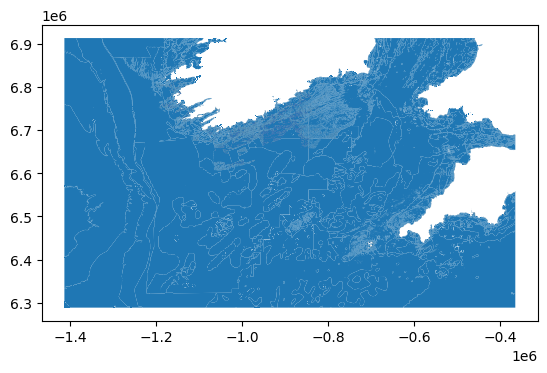

In [57]:
gdf.plot()

In [38]:
gdf.to_file('../data/dataframe.geojson', driver='GeoJSON')

OPEN EMODNET SEABED 2019

In [3]:
# https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open/wfs?SERVICE=WFS&request=getFeature&VERSION=2.0.0&typeName=emodnet_open:eusm2021_bio_full&outputFormat=application/json&bbox=-1413232,6288190,-365497,6914553"

In [4]:
url = "https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open/wfs?"
options = {
    'SERVICE':'WFS',
    'request':'getFeature',
    'VERSION':'2.0.0',
    'typeName':'emodnet_open:eusm2021_bio_full',
    'outputFormat':'application/json',
    'bbox':'-1413232,6288190,-365497,6914553'
}
output = 'haigfras_biozones.geojson'
bbox=[-1413232,6288190,-365497,6914553]

In [30]:
from process_emodnet_geojson import ProcessGeoJson

In [31]:
p = ProcessGeoJson(input_url = url, input_options = options, output=output, bbox=bbox)

In [32]:
p.download_emodnet_wfs()

downloading data
data downloaded


In [33]:
p.clip_geojson()

In [39]:
p.file_clipped

'clipped_haigfras_biozones.geojson'

In [41]:
remote_path = f"s3://{p.bucket}/{p.file_clipped}"
remote_path

's3://haig-fras/clipped_haigfras_biozones.geojson'

In [52]:
from s3fs import S3FileSystem
s3 = S3FileSystem(anon=False,
                key=p.__jasmin_token,
                secret=p.__jasmin_secret,
                client_kwargs={"endpoint_url": p.__jasmin_api_url})

remote_path = f"s3://{p.bucket}/{p.file_clipped}"


In [53]:
with s3.open(remote_path, mode="wb", s3=dict(profile="default")) as remote_file:
    with open(f'data/{p.file_clipped}', mode="rb") as local_file:
        remote_file.write(local_file.read())

In [38]:
p.upload_jasmine()

Unable to locate credentials


NoCredentialsError: Unable to locate credentials

In [18]:
with open(p.output) as f:
    gj = geojson.load(f)

In [22]:
gj['features'][0]['properties']

{'euseamap_r': 'Atlanto-Arctic',
 'shape_leng': 363108002.913,
 'shape_area': 40035564441600}

In [ ]:
class ProcessGeoJson():


In [127]:
url_file = "https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open/wfs?SERVICE=WFS&request=getFeature&VERSION=2.0.0&typeName=emodnet_open:eusm2019_regions&outputFormat=application/json&bbox=-1413232,6288190,-365497,6914553"
r = requests.get(url_file)

In [128]:
with open('haigfras_seabed_2019.geojson', 'w') as f:
   dump(r.json(), f)
with open('data/haigfras.geojson') as f:
    gj = geojson.load(f)

'/home/tobfer/code/noc-gitlab/imfe-pilot/scripts/files_to_geojson/notebooks'

In [9]:
df = geopandas.read_file('../data/haigfras_biozones.geojson')

In [13]:
df[.biozone.unique()

array(['Atlantic lower abyssal', 'Atlantic mid bathyal',
       'Atlantic upper abyssal', 'Atlantic lower bathyal',
       'Atlantic mid abyssal', 'Atlantic upper bathyal',
       'Atlanto-Mediterranean mid bathyal', 'Deep circalittoral',
       'Infralittoral', 'Shallow circalittoral'], dtype=object)

In [ ]:
gj.feature

In [135]:
len(gj['features'][0])

6

In [132]:
df = geopandas.read_file('haigfras_seabed_2019.geojson')
new_df = geopandas.clip(gdf=df, mask=[-1413232,6288190,-365497,6914553], keep_geom_type=False)

DriverError: Failed to read GeoJSON data

OPEN EMODNET SEABED SUBSTRATE

In [ ]:
url_file = "https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open/wfs?SERVICE=WFS&request=getFeature&VERSION=2.0.0&typeName=emodnet_open:eusm2021_subs_full&outputFormat=application/json&bbox=-1413232,6288190,-365497,6914553"
r = requests.get(url_file)

In [ ]:
with open('haigfras_seabed_substrate.geojson', 'w') as f:
   dump(r.json(), f)
with open('haigfras_seabed_substrate.geojson') as f:
    gj = geojson.load(f)

In [ ]:
for item in gj['features']:
    del item["properties"]['geom_200']
    del item["properties"]['geom_400']
    del item["properties"]['geom_800']
    
with open('haigfras_substrate.geojson', 'w') as f:
   dump(gj, f)

In [3]:
with open('haigfras_substrate.geojson') as f:
    gj = geojson.load(f)

In [4]:
len_total = len(gj['features'])

In [5]:
import numpy as np

In [ ]:
gdf = geopandas.GeoDataFrame()
for i in np.arange(0,len_total,1000):
    print(i)
    try:
        df = geopandas.read_file("haigfras_substrate.geojson", rows=slice(i,i+1000), bbox=(-1413232,6288190,-365497,6914553))
        gdf = gdf.append(df)        
    except Exception as e:
        print(e)

0
Failed to read GeoJSON data
1000
Failed to read GeoJSON data
2000
Failed to read GeoJSON data
3000
Failed to read GeoJSON data
4000
Failed to read GeoJSON data
5000
Failed to read GeoJSON data
6000
Failed to read GeoJSON data
7000


KeyboardInterrupt: 

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "/home/tobfer/.pyenv/versions/3.10.6/lib/python3.10/logging/__init__.py", line 2071, in getLogger
    def getLogger(name=None):
KeyboardInterrupt: 


Failed to read GeoJSON data
8000
Failed to read GeoJSON data
9000
Failed to read GeoJSON data
10000
Failed to read GeoJSON data
11000
Failed to read GeoJSON data
12000
Failed to read GeoJSON data
13000
Failed to read GeoJSON data
14000
Failed to read GeoJSON data
15000
Failed to read GeoJSON data
16000
Failed to read GeoJSON data
17000
Failed to read GeoJSON data
18000
Failed to read GeoJSON data
19000
Failed to read GeoJSON data
20000
Failed to read GeoJSON data
21000
Failed to read GeoJSON data
22000
Failed to read GeoJSON data
23000
Failed to read GeoJSON data
24000
Failed to read GeoJSON data
25000
Failed to read GeoJSON data
26000
Failed to read GeoJSON data
27000
Failed to read GeoJSON data
28000
Failed to read GeoJSON data
29000
Failed to read GeoJSON data
30000
Failed to read GeoJSON data
31000
Failed to read GeoJSON data
32000
Failed to read GeoJSON data
33000
Failed to read GeoJSON data
34000
Failed to read GeoJSON data
35000
Failed to read GeoJSON data
36000
Failed to read G

In [ ]:
df = geopandas.read_file("nybb.shp", rows=10)  
Reading only geometries intersecting mask:

df = geopandas.read_file("nybb.shp", mask=polygon)  
Reading only geometries intersecting bbox:

df = geopandas.read_file("nybb.shp", bbox=(0, 0, 10, 20))  

In [7]:
from osgeo import gdal

ds = gdal.OpenEx('haigfras_seabed_substrate.geojson')


In [18]:
ds.GetMetadata()

{}

In [8]:
layer = ds.GetLayer()
feature = layer.GetFeature(0)

print(ds.GetDriver().ShortName)
print(feature.GetGeometryRef().ExportToWkt())

GeoJSON
MULTIPOLYGON (((-599332.2698 6454384.9905,-599427.1741 6454351.375,-599471.8467 6454438.9994,-599324.9319 6454393.1538,-599332.2698 6454384.9905)))


In [9]:
print(feature.GetGeometryRef())

MULTIPOLYGON (((-599332.2698 6454384.9905,-599427.1741 6454351.375,-599471.8467 6454438.9994,-599324.9319 6454393.1538,-599332.2698 6454384.9905)))


In [ ]:
layer = ds.GetLayer()
feature = layer.GetFeature(0)

In [19]:
len(gj['features'])

159757

In [15]:
gj['features'][0]['properties']

{'substrate': 'Sediment',
 'shape_length': 363.915041575287,
 'shape_area': 5676.67207266843,
 'geom_200': {"coordinates": [], "type": "MultiPolygon"},
 'geom_400': {"coordinates": [], "type": "MultiPolygon"},
 'geom_800': {"coordinates": [], "type": "MultiPolygon"}}

In [16]:
for item in gj['features']:
    del item["properties"]['geom_200']
    del item["properties"]['geom_400']
    del item["properties"]['geom_800']
with open('haigfras_substrate.geojson', 'w') as f:
   dump(gj, f)

In [23]:
with open('haigfras_substrate.geojson', 'w') as f:
   dump(gj, f)

In [36]:
len(gj.features)

159757

In [44]:
input_path = Path('./')
files = list(input_path.glob("*_xaaa*.geojson"))

In [61]:
gdf = geopandas.GeoDataFrame()
for 
for file in files:
    print(file)
    try:
        df = geopandas.read_file(str(file))
        new_df = geopandas.clip(gdf=df, mask=[-1413232,6288190,-365497,6914553], keep_geom_type=False)
        new_df.to_json()
        gdf = gdf.append(new_df)        
    except Exception as e:
        print(e)

haigfras_substrate_xaaaa.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaao.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaam.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaaq.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaae.geojson
Failed to read GeoJSON data
haigfras_substrate_xaaah.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaag.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaal.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaab.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaai.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaaf.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaak.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaad.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaac.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaaj.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaap.geojson


/tmp/ipykernel_30873/510254483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


In [77]:
with open('haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabe.geojson') as f:
    gj = geojson.load(f)

In [113]:
gj['features'][0]['properties']

{'substrate': 'Coarse substrate',
 'shape_length': 45952962.0972195,
 'shape_area': 13953138588.7864}

In [114]:
with open('haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabe.geojson') as f:
    gj = geojson.load(f)

output = { "type": "FeatureCollection", "features": [] }

for feature in gj['features']:
    if (feature['geometry'] is not None) and (feature['geometry']['type'] == 'MultiPolygon'):
        for poly in feature['geometry']['coordinates'][0]:
            xfeature = { "type": "Feature", "properties": feature['properties'], "geometry": { "type": "Polygon" } }
            xfeature['geometry']['coordinates'] = poly
            output['features'].append(xfeature)

with open('polygons.geojson', 'w') as f:
   dump(output.json(), f)

52204141

In [120]:
with open('polygons.geojson', 'w') as f:
   dump(output, f)

In [ ]:
gj['features'][0]['geometry']['coordinates'][0][2]

In [121]:
df = geopandas.read_file('polygons.geojson')

In [122]:
df

,substrate,shape_length,shape_area,geometry
0,Coarse substrate,4.595296e+07,1.395314e+10,None
1,Coarse substrate,4.595296e+07,1.395314e+10,None
2,Coarse substrate,4.595296e+07,1.395314e+10,None
3,Coarse substrate,4.595296e+07,1.395314e+10,None
4,Coarse substrate,4.595296e+07,1.395314e+10,None
...,...,...,...,...
28374,Coarse substrate,4.595296e+07,1.395314e+10,None
28375,Coarse substrate,4.595296e+07,1.395314e+10,None
28376,Coarse substrate,4.595296e+07,1.395314e+10,None
28377,Coarse substrate,4.595296e+07,1.395314e+10,None


In [69]:
input_path = Path('./')
files = list(input_path.glob("*_xaaae_xaaac_xaaab_x*.geojson"))

In [70]:
for file in files:
    print(file)
    try:
        df = geopandas.read_file(str(file))
        new_df = geopandas.clip(gdf=df, mask=[-1413232,6288190,-365497,6914553], keep_geom_type=False)
        new_df.to_json()
        gdf = gdf.append(new_df)        
    except Exception as e:
        print(e)

haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabg.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaal.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaai.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaad.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabf.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaao.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaaj.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaae.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaab.geojson


/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipyke

haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaby.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaaw.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaaj.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabo.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabw.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaaa.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaag.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaaq.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaab.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabh.geojson


/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaac.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabe.geojson
Failed to read GeoJSON data
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabz.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabi.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabp.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaar.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabm.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaay.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaav.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaah.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabx.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaah.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaac.geojson


/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipyke

haigfras_substrate_xaaae_xaaac_xaaab_xaaaf.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabu.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabc.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaax.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabs.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaae.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabq.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabl.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaam.geojson


/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaap.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaat.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaad.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabd.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai.geojson
Failed to read GeoJSON data
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaaz.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabj.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabk.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaau.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaba.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabt.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaas.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabv.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaaa.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabr.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaag.geojson


/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipyke

haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaabb.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaaf.geojson
haigfras_substrate_xaaae_xaaac_xaaab_xaaai_xaaak.geojson


/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)
/tmp/ipykernel_30873/2782387842.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(new_df)


<AxesSubplot:>

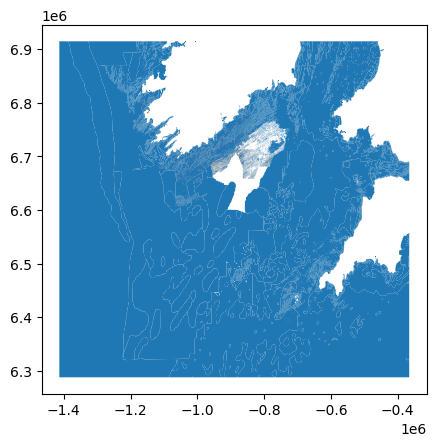

In [76]:
gdf.plot()

OPEN EMODNET SEABED BIOZONES

In [13]:
url_file = "https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open/wfs?SERVICE=WFS&request=getFeature&VERSION=2.0.0&typeName=emodnet_open:eusm2021_bio_full&outputFormat=application/json&bbox=-1413232,6288190,-365497,6914553"
r = requests.get(url_file)
with open('haigfras_seabed.geojson', 'w') as f:
   dump(r.json, f)
with open('haigfras_seabed.geojson') as f:
    gj = geojson.load(f)

In [14]:
for item in gj['features']:
    del item["properties"]['geom_200']
    del item["properties"]['geom_400']
    del item["properties"]['geom_800']

In [84]:
with open('haigfras.geojson', 'w') as f:
   dump(gj, f)

In [24]:
# gj['features'][0].keys()

dict_keys(['type', 'geometry_name', 'bbox', 'id', 'geometry', 'properties'])

In [2]:
df = geopandas.read_file('haigfras.geojson')
new_df = geopandas.clip(gdf=df, mask=[-1413232,6288190,-365497,6914553], keep_geom_type=False)

In [56]:
# df_exploded = df.explode(column='geometry')

/tmp/ipykernel_10620/477122882.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_exploded = df.explode(column='geometry')


In [4]:
new_df.to_file("haigfras_jasmin.geojson", driver='GeoJSON')


In [94]:
new_df.head(10)

,id,biozone,shape_length,shape_area,geometry
2,eusm2021_bio_full.95785,Atlantic upper abyssal,9.874703e+07,2.060958e+12,"POLYGON ((-1413232.000 6403810.186, -1413232.0..."
1002,eusm2021_bio_full.42856,Atlantic lower bathyal,1.235303e+08,2.269562e+12,"MULTIPOLYGON (((-1413232.000 6333391.140, -141..."
2019,eusm2021_bio_full.122340,Atlanto-Mediterranean mid bathyal,5.861292e+02,2.053691e+04,"POLYGON ((-1404017.078 6292023.474, -1403901.1..."
11,eusm2021_bio_full.33787,Atlantic lower bathyal,5.861362e+02,2.053732e+04,"POLYGON ((-1403901.120 6292023.474, -1404017.0..."
2022,eusm2021_bio_full.122341,Atlanto-Mediterranean mid bathyal,9.403948e+02,4.107684e+04,"POLYGON ((-1404480.909 6292731.938, -1404480.9..."
2023,eusm2021_bio_full.122342,Atlanto-Mediterranean mid bathyal,5.861660e+02,2.053905e+04,"POLYGON ((-1404944.740 6292909.063, -1404828.7..."
2024,eusm2021_bio_full.122343,Atlanto-Mediterranean mid bathyal,5.861736e+02,2.053949e+04,"POLYGON ((-1404944.740 6292909.063, -1405060.6..."
2025,eusm2021_bio_full.122344,Atlanto-Mediterranean mid bathyal,5.861814e+02,2.053995e+04,"POLYGON ((-1404712.824 6293086.192, -1404828.7..."
14,eusm2021_bio_full.33790,Atlantic lower bathyal,5.862110e+02,2.054166e+04,"POLYGON ((-1404248.993 6293794.746, -1404364.9..."
15,eusm2021_bio_full.33791,Atlantic lower bathyal,3.285439e+03,2.465115e+05,"POLYGON ((-1404944.740 6293794.746, -1405060.6..."


In [95]:
len(new_df.id.unique())

9054

<AxesSubplot:>

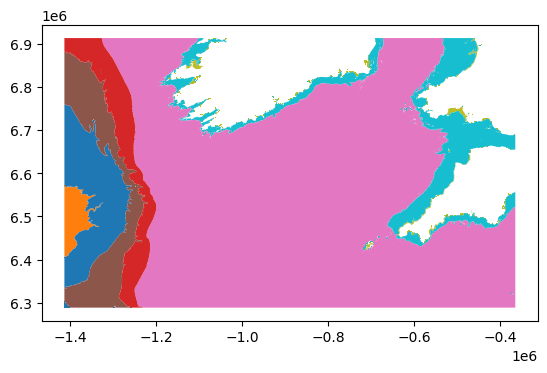

In [70]:
new_df.plot(column='biozone')

In [ ]:
features = []
for i, y in enumerate(xds.y.values):
    for j, x in enumerate(xds.x.values):
        point = Point((y, x))
        feature = Feature(geometry=point,  properties = {'depth': int(xds.values[0][i][j].round(0))})
        features.append(feature)

In [10]:
import gdaltools
import geopandas

In [5]:
ogr = gdaltools.ogr2ogr()

In [6]:
ogr.set_input("myfile_3.geojson", srs="EPSG:3857")
ogr.set_output("myfile_7.geojson", srs="EPSG:4326")
ogr.execute()

b''

In [ ]:
conn = gdaltools.PgConnectionString(host="localhost", port=5432, dbname="scolab", schema="data", user="myuser", password="mypass")
ogr.set_input(conn, table_name="roads", srs="EPSG:4326")
ogr.set_output("mydb.sqlite", srs="EPSG:25830")
ogr.execute()

In [41]:
import geojson
with open(url_file) as f:
    gj = geojson.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open/wfs?SERVICE=WFS&request=getFeature&VERSION=2.0.0&typeName=emodnet_open:eusm2021_bio_full&outputFormat=application/json'